# Periodic homogenization of linear elastic materials

This notebook is developed based on the tutorial **Numerical Tours of Computational Mechanics with FEniCS** to solve a microscopic boundary value problem arising the computational homogenization of linear elastic materials.

In this notebook, I try to give one example that illustrates inconsistencies between the results obtained in this notebook and those obtained in the tutorial. I think there might be some minor bug or mistakes in the tutorial due to three reasons.

1. The macroscopic stiffness is not symmetric. Theoretically, this property should be (largely) independent of the mesh discretization in the finite element method as it holds true for the continuous setting (exact solution).
2. The homogenized with the circular inclusion should be isotropic so that the macroscopic tangent can be defined by $\overline{\lambda}$ and $\overline{\mu}$ which are the homogenized Lame parameters.
3. The components of the macroscopic tangent should be non-negative.

For the above three reasons, I am afraid that there could be some minor bugs in the implementation. This notebook provides a another implementation that produces numerical results that respect the properties mentioned in the above bullets.

In [82]:
from __future__ import print_function
from dolfin import *
import numpy as np
import mshr
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

## Generate mesh and create periodic boundary class

The mesh provided by the class **mshr** and its method *generate_mesh* automatically produces periodic mesh. This can be justified by examining the nodes of boundaries and easily seen for the simple case of UnitSquareMesh. Therefore, we will use the class **mshr** for our mesh generation and do not need to rely on the **gmsh** at this point.

volume =  1.0


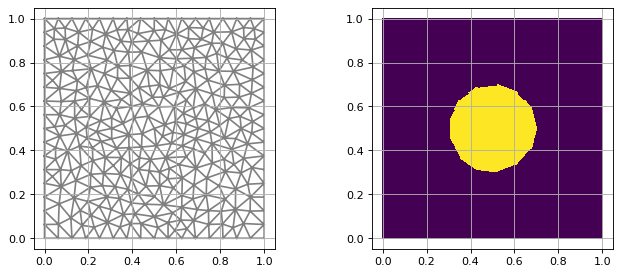

In [85]:
# Create domain, mark subdomains and generate mesh

RVE_structure = 'square'
if RVE_structure == 'parallelogram':
    vertices = np.array([[0, 0], [1, 0.25], [1.25, 1.25], [0.25, 1]])
elif RVE_structure == 'square':
    vertices = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

inclusion_coords = 0.5 * np.sum(vertices[[0, 2], :], 0)
inclusion = mshr.Circle(Point(inclusion_coords), 0.2)
domain = mshr.Polygon([Point(vertices[0,:]), Point(vertices[1,:]), 
                       Point(vertices[2,:]), Point(vertices[3,:])])
domain.set_subdomain(1, inclusion)

mesh = mshr.generate_mesh(domain, 12)
subdomain_marker = MeshFunction('size_t', mesh, mesh.topology().dim(),
                               mesh.domains())

# Compute volume of RVE
a = np.zeros((2, 2))      # direction vectors that define RVE.
a[0,:] = vertices[1,:] - vertices[0,:]
a[1,:] = vertices[3,:] - vertices[0,:]
vol = np.linalg.det(a); print("volume = ", vol)

# Vectors normal to direction vectors a.
n = np.zeros((2, 2))
n[0,:] = [a[0, 1], -a[0, 0]]
n[1,:] = [a[1, 1], -a[1, 0]]

assert np.dot(a[0,:], n[0,:]) < 1E-15
assert np.dot(a[1,:], n[1,:]) < 1E-15

# Plot the mesh and subdomains
plt.figure(figsize=(10, 4), dpi = 80)
plt.subplot(1,2,1)
plot(mesh); plt.grid()
plt.subplot(1,2,2)
plot(subdomain_marker); plt.grid()

By default, the **mshr** class can give us the periodic mesh. Therefore, we don't rely on **gmsh** in this notebook to create a mesh satisfying the periodicity.

In [86]:
# Check if the nodes on the left and the right boundaries are symmetric (periodic).
# left boundary is detected by the condition: the vector (x - v[0,:]) must be orthogonal to n[1,:].
xx = mesh.coordinates()[:,0]
yy = mesh.coordinates()[:,1]
coords = mesh.coordinates()
x_vector = coords - vertices[0,:]
left_idx = np.argwhere(abs(np.dot(n[1,:], x_vector.T)) < 1E-10).ravel()
bottom_idx = np.argwhere(abs(np.dot(n[0,:], x_vector.T)) < 1E-10).ravel()
# right boundary is detected by the condition: the vector (x - v[1,:]) is orthogonal to n[1,:]
x_vector = coords - vertices[1,:]
right_idx = np.argwhere(abs(np.dot(n[1,:], x_vector.T)) < 1E-10).ravel()
top_idx = np.argwhere(abs(np.dot(n[0,:], (coords - vertices[3,:]).T)) < 1E-10).ravel()

# sort the nodes in y-coordinates for the left and right edges
left_idx = left_idx[np.argsort(yy[left_idx])]
right_idx = right_idx[np.argsort(yy[right_idx])]

# Sort the nodes in the x-coordinates for the bottom and top edges
bottom_idx = bottom_idx[np.argsort(xx[bottom_idx])]
top_idx = top_idx[np.argsort(xx[top_idx])]
# check periodicity
print("left-right periodic: ", np.allclose(coords[right_idx] - coords[left_idx], a[0,:]))
print("bottom-top periodic: ", np.allclose(coords[top_idx] - coords[bottom_idx], a[1,:]))

left-right periodic:  True
bottom-top periodic:  True


In [87]:
# class used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    # Constructor
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.TOL = TOL
        self.vertices = vertices
        # vectors generating periodicity
        self.a = np.zeros((2, 2))
        self.a[0,:] = vertices[1,:] - vertices[0,:]
        self.a[1,:] = vertices[3,:] - vertices[0,:]
        
        # vectors normal to vectors a[0,:] and a[1,:]
        self.n = np.zeros((2,2))
        self.n[0,:] = [ -self.a[0,1], self.a[0,0] ]
        self.n[1,:] = [ -self.a[1,1], self.a[1,0] ]
        
        assert np.dot(self.n[0,:], self.a[0,:]) < self.TOL
        assert np.dot(self.n[1,:], self.a[1,:]) < self.TOL
    
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        top_left = np.allclose(x, self.vertices[3,:], self.TOL)
        bottom_right = np.allclose(x, self.vertices[1,:], self.TOL)
        x_vector = x - self.vertices[0,:]
        bottom = (np.abs(np.dot(self.n[0,:], x_vector)) < self.TOL)
        left = (np.abs(np.dot(self.n[1,:], x_vector)) < self.TOL)
            
        return (left or bottom) and \
            (not (top_left or bottom_right)) and on_boundary
    # Map right boundary (R) to the left boundary (L)
    def map(self, x, y):
        # top right node
        if np.allclose(x, self.vertices[2,:]):
            y[0] = x[0] - (self.a[0, 0] + self.a[1,0])
            y[1] = x[1] - (self.a[0, 1] + self.a[1,1])
        # right boundary
        elif np.abs(np.dot(self.n[1,:], x - self.vertices[1,:])) < self.TOL:
            y[0] = x[0] - self.a[0,0]
            y[1] = x[1] - self.a[0,1]
        # top boundary
        else:  
            y[0] = x[0] - self.a[1,0]
            y[1] = x[1] - self.a[1,1]

pbc = PeriodicBoundary(vertices)

### Define and solve microscopic BVP

We now define the constitutive law for both phases. We employ the energy density for linear isotropic elasicity
\begin{equation}
    \psi = \frac{\lambda}{2} \mathrm{trace}(\boldsymbol{\epsilon})^2 + \mu\,{} \mathrm{trace}(\boldsymbol{\epsilon}^2).
\end{equation}
The Lame parameters $\lambda$ and $\mu$ are computed in terms of the Young's modulus and Poisson ratio as follows:
\begin{equation}
    \lambda = \frac{E \nu}{(1 + \nu) (1 - 2\nu}, \quad \mu = \frac{E}{2(1 + \nu)}.
\end{equation}

The stress tensor $\boldsymbol{\sigma}$ is derived as
\begin{equation}
    \boldsymbol{\sigma} = \lambda \mathrm{trace}(\boldsymbol{\epsilon})\mathbf{I} + 2\mu \boldsymbol{\epsilon}
\end{equation}
The tangent stiffness, which is linear in this case, is given by
\begin{equation}
    C_{ijkl} = \lambda \delta_{ij}\delta_{kl} + \mu(\delta_{il}\delta_{jk} + \delta_{ik}\delta_{jl})
\end{equation}
Due to the symmetries of the $\boldsymbol{\delta}$, the stiffness is (1) majorly symmetric: $C_{ijkl} = C_{klij}$ and (2) minorly symmetric: $C_{ijkl} = C_{jikl} = C_{ijlk}$.

Since both $\lambda$ and $\mu$ can be scaled by a multiplicative factor $E$, we can define the normalized energy density as
\begin{equation}
    \overline{\psi} = \frac{1}{E} \psi = \frac{ \overline{\lambda}}{2} \mathrm{trace}(\boldsymbol{\epsilon})^2 + \overline{\mu}\,{} \mathrm{trace}(\boldsymbol{\epsilon}^2), \qquad \overline{\lambda} = \frac{\lambda}{E}, \overline{\mu} = \frac{\mu}{E}
\end{equation}
By using the normalized energy density, we can focus on the phase contrast between the matrix and inclusion materials. Using the normalized energy density, the numerical results are normally more reliable. This technique is not necessary for this simple problem but it is done in this notebook.

In [88]:
# material parameters for the matrix and inclusion
E = np.array([50e3, 210e3])
E_ratio = E/np.min(E)
nu = np.array([0.2, 0.3])
num_phases = len(E)
lambda_ = E_ratio * nu /(1 + nu)/(1 - 2*nu)
mu_ = 0.5 * E_ratio / (1 + nu)
# define strain and stress tensors
def epsilon(v):
    return sym(grad(v))

def sigma(v, MacroStrain, phase):
    return lambda_[phase]*tr(sym(grad(v)) + MacroStrain)*Identity(2) \
            + 2*mu_[phase]*(sym(grad(v)) + MacroStrain)

In [153]:
Ve = VectorElement("CG", mesh.ufl_cell(), 1)     # Lagrange elements
Re = VectorElement("R", mesh.ufl_cell(), 0)      # Scalar values
W_Mixed = FunctionSpace(mesh, MixedElement([Ve, Re]),
                  constrained_domain=pbc)

(u, c) = TrialFunctions(W_Mixed)
(v, d) = TestFunctions(W_Mixed)

dx = Measure('dx', subdomain_data=subdomain_marker)

MacroStrain = Constant(np.array([[0.05, 0], 
                                 [0,     0.0]]))    # macroscopic strain
# bilinear form and linear form
F = sum([inner(sigma(u, MacroStrain, i), epsilon(v))*dx(i) for i in range(2)]) + dot(c, v)*dx + dot(u, d)*dx
a, L = lhs(F), rhs(F)

# solve the variational problem
sol = Function(W_Mixed)
solve(a == L, sol, [])

u_fluc, lagrange_mul = sol.split()    # fluctuation displacemet

epsilon_fluc = epsilon(u_fluc)    # fluctuation strain field

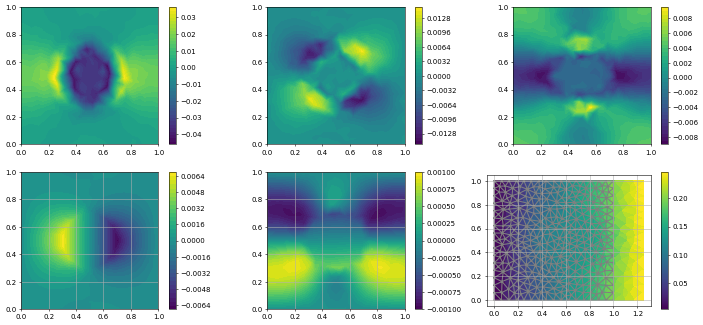

In [154]:
# plot fluctuation displacements and fluctuation strains
plt.figure(figsize=(18, 8), dpi=50)

for j in range(3):
    plt.subplot(2, 3, j+1)
    plt.colorbar(plot(epsilon_fluc[int(idx[j, 0]), int(idx[j, 1])]))
    
for j in range(2):
    plt.subplot(2, 3, j+4)
    plt.colorbar(plot(u_fluc[j])); plt.grid()
    

    
# plotting deformed unit cell with total displacement u = MacroStrain*y + v
y = SpatialCoordinate(mesh)
plt.subplot(2, 3, 6)
plot(mesh); plt.colorbar( plot( zoom_scale * (0.5*(dot(MacroStrain, y)+ u_fluc)), mode="displacement") ); plt.grid()
# plt.axis([-0.1, 1.2, -0.2, 1.2])

### Macroscopic elastic tensor (macroscopic tangent)

In [155]:
I = np.eye(3, 3)
w = Function(W_Mixed)
C_Macro = np.zeros((3, 3))
for irun in range(3):
    MacroStrain = Constant(np.array([ [I[0, irun], I[2, irun]/2],
                                    [I[2, irun]/2, I[1, irun] ]]))

    F = sum([inner(sigma(u, MacroStrain, i), epsilon(v))*dx(i) for i in range(2)]) + dot(c, v)*dx + dot(u, d)*dx
    a, L = lhs(F), rhs(F)
    solve(a == L, w, [])

    (u_Fluc, lagrange_mul) = w.split()

    stress_tensor = np.array([[assemble(
                        sigma(u_Fluc, MacroStrain, 0)[i,j]*dx(0) \
                        + sigma(u_Fluc, MacroStrain, 1)[i,j]*dx(1)) \
                        for i in range(2)] for j in range(2)])
    C_Macro[:, irun] = np.array([stress_tensor[0,0], 
                                 stress_tensor[1,1], 
                                 stress_tensor[0,1]])/vol
    
print("C_Macro =")
print(C_Macro)

C_Macro =
[[ 1.28116131e+00  3.32553823e-01 -1.44722815e-05]
 [ 3.32553823e-01  1.28093896e+00  5.60524427e-05]
 [-1.44722815e-05  5.60524427e-05  4.68184190e-01]]


In [156]:
## Validate isotropic materials:
# Symmetric.
print("Symmetric =", np.allclose(C_Macro, C_Macro.T))

# C_Macro[0, 0] = Lambda + 2*Mu
# C_Macro[0, 1] = Lambda
# C_Macro[2, 2] = Mu
print("C_{11} == C_{12} + C_{33}:", np.allclose(C_Macro[0,0], C_Macro[0,1] + 2*C_Macro[2,2], 1E-2))

print(C_Macro[0, 0])
print(C_Macro[0,1] + 2*C_Macro[2,2])

Symmetric = True
C_{11} == C_{12} + C_{33}: True
1.2811613109644773
1.2689222030784033
